In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
data_path = '/content/drive/My Drive/solar_panel/dataset'

In [3]:
!ls '/content/drive/My Drive/solar_panel/dataset'

best_dmnet.pth	train  train.txt  val  val.txt


In [4]:
import os

SAVE_DIR = "/content/drive/My Drive/solar_panel/dataset"
os.makedirs(SAVE_DIR, exist_ok=True)




#Creating Dataset and DataLoaders

In [6]:
import os
import random
import torch
import torch.nn.functional as F                   # for interpolate, etc.
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms as T
import torchvision.transforms.functional as TF    # for resize, flip, normalize, etc.


In [14]:
class SolarSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            transformed = self.transform(image, mask)
            image, mask = transformed

        return image, mask



In [15]:
class SegmentationTransform:
    def __init__(self, resize=(400, 400)):
        self.resize = resize

    def __call__(self, image, mask):
        # Resize
        image = TF.resize(image, self.resize)
        mask = torch.as_tensor(np.array(mask) / 255.0, dtype=torch.float32)


        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Convert to tensor
        image = TF.to_tensor(image)
        mask = torch.as_tensor(np.array(mask), dtype=torch.long)

        # Normalize image (ImageNet mean/std)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
        return image, mask



In [16]:
train_dataset = SolarSegmentationDataset(
    img_dir='/content/drive/MyDrive/solar_panel/dataset/train/img',
    mask_dir='/content/drive/MyDrive/solar_panel/dataset/train/mask',
    transform=SegmentationTransform()
)

val_dataset = SolarSegmentationDataset(
    img_dir='/content/drive/MyDrive/solar_panel/dataset/val/img',
    mask_dir='/content/drive/MyDrive/solar_panel/dataset/val/mask',
    transform=SegmentationTransform()
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


#DMNet (Deep Multiscale Network) for binary segmentation

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm


In [11]:
class DMNet(nn.Module):
    def __init__(self, n_classes=1):
        super(DMNet, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Encoder layers
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # Decoder (simple upsampling + skip connections)
        self.up4 = nn.ConvTranspose2d(2048, 512, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(512 + 1024, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256 + 512, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128 + 256, 64, kernel_size=2, stride=2)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
      # Encoder
      x0 = self.layer0(x)
      x1 = self.layer1(x0)
      x2 = self.layer2(x1)
      x3 = self.layer3(x2)
      x4 = self.layer4(x3)

      # Decoder
      x = self.up4(x4)
      x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=False)
      x = torch.cat([x, x3], dim=1)

      x = self.up3(x)
      x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=False)
      x = torch.cat([x, x2], dim=1)

      x = self.up2(x)
      x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=False)
      x = torch.cat([x, x1], dim=1)

      x = self.up1(x)
      x = F.interpolate(x, size=(400, 400), mode='bilinear', align_corners=False)

      x = self.final(x)
      return torch.sigmoid(x)




In [12]:
def dice_loss(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, preds, targets):
        bce = self.bce(preds, targets.float())
        dice = dice_loss(preds, targets)
        return bce + dice


In [ ]:
import torchvision.models as models

resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # force fresh download

def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DMNet().to(device)
criterion = BCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
best_iou = 0
train_losses, val_losses = [], []


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, masks = images.to(device), masks.unsqueeze(1).to(device)
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss, iou = 0, 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, masks = images.to(device), masks.unsqueeze(1).to(device)
            preds = model(images)
            val_loss += criterion(preds, masks).item()
            iou += iou_score(preds, masks).mean().item()
    val_loss /= len(val_loader)
    iou /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {iou:.4f}")

    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), f"{SAVE_DIR}/best_dmnet.pth")
        print(f"Saved new best model (IoU={best_iou:.4f})")


Epoch 1/50 [Val]: 100%|██████████| 201/201 [19:33<00:00,  5.84s/it]


Epoch 1/50 | Train Loss: 0.2094 | Val Loss: 0.0959 | Val IoU: 0.8559
Saved new best model (IoU=0.8559)


Epoch 2/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.65it/s]


Epoch 2/50 | Train Loss: 0.0790 | Val Loss: 0.0750 | Val IoU: 0.8848
Saved new best model (IoU=0.8848)


Epoch 3/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 18.02it/s]


Epoch 3/50 | Train Loss: 0.0701 | Val Loss: 0.0702 | Val IoU: 0.8929
Saved new best model (IoU=0.8929)


Epoch 4/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.95it/s]


Epoch 4/50 | Train Loss: 0.0648 | Val Loss: 0.0633 | Val IoU: 0.9005
Saved new best model (IoU=0.9005)


Epoch 5/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.97it/s]


Epoch 5/50 | Train Loss: 0.0607 | Val Loss: 0.0630 | Val IoU: 0.9031
Saved new best model (IoU=0.9031)


Epoch 6/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.83it/s]


Epoch 6/50 | Train Loss: 0.0524 | Val Loss: 0.0609 | Val IoU: 0.9066
Saved new best model (IoU=0.9066)


Epoch 7/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.65it/s]


Epoch 7/50 | Train Loss: 0.0517 | Val Loss: 0.0691 | Val IoU: 0.8968


Epoch 8/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.71it/s]


Epoch 8/50 | Train Loss: 0.0556 | Val Loss: 0.0590 | Val IoU: 0.9075
Saved new best model (IoU=0.9075)


Epoch 9/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.59it/s]


Epoch 9/50 | Train Loss: 0.0516 | Val Loss: 0.0574 | Val IoU: 0.9089
Saved new best model (IoU=0.9089)


Epoch 10/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.79it/s]


Epoch 10/50 | Train Loss: 0.0473 | Val Loss: 0.0576 | Val IoU: 0.9102
Saved new best model (IoU=0.9102)


Epoch 11/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.63it/s]


Epoch 11/50 | Train Loss: 0.0546 | Val Loss: 0.0626 | Val IoU: 0.9051


Epoch 12/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.65it/s]


Epoch 12/50 | Train Loss: 0.0450 | Val Loss: 0.0558 | Val IoU: 0.9113
Saved new best model (IoU=0.9113)


Epoch 13/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.45it/s]


Epoch 13/50 | Train Loss: 0.0455 | Val Loss: 0.0564 | Val IoU: 0.9135
Saved new best model (IoU=0.9135)


Epoch 14/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.53it/s]


Epoch 14/50 | Train Loss: 0.0433 | Val Loss: 0.0562 | Val IoU: 0.9125


Epoch 15/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.66it/s]


Epoch 15/50 | Train Loss: 0.0432 | Val Loss: 0.0719 | Val IoU: 0.9021


Epoch 16/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.55it/s]


Epoch 16/50 | Train Loss: 0.0429 | Val Loss: 0.0573 | Val IoU: 0.9133


Epoch 17/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.47it/s]


Epoch 17/50 | Train Loss: 0.0439 | Val Loss: 0.0797 | Val IoU: 0.8952


Epoch 18/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.38it/s]


Epoch 18/50 | Train Loss: 0.0449 | Val Loss: 0.0633 | Val IoU: 0.9080


Epoch 19/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.43it/s]


Epoch 19/50 | Train Loss: 0.0415 | Val Loss: 0.0550 | Val IoU: 0.9133


Epoch 20/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.73it/s]


Epoch 20/50 | Train Loss: 0.0394 | Val Loss: 0.0525 | Val IoU: 0.9163
Saved new best model (IoU=0.9163)


Epoch 21/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.52it/s]


Epoch 21/50 | Train Loss: 0.0449 | Val Loss: 0.0548 | Val IoU: 0.9141


Epoch 22/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.51it/s]


Epoch 22/50 | Train Loss: 0.0386 | Val Loss: 0.0534 | Val IoU: 0.9153


Epoch 23/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.33it/s]


Epoch 23/50 | Train Loss: 0.0365 | Val Loss: 0.0556 | Val IoU: 0.9150


Epoch 24/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.78it/s]


Epoch 24/50 | Train Loss: 0.0359 | Val Loss: 0.0603 | Val IoU: 0.9099


Epoch 25/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.55it/s]


Epoch 25/50 | Train Loss: 0.0392 | Val Loss: 0.0568 | Val IoU: 0.9144


Epoch 26/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.50it/s]


Epoch 26/50 | Train Loss: 0.0408 | Val Loss: 0.0558 | Val IoU: 0.9145


Epoch 27/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.54it/s]


Epoch 27/50 | Train Loss: 0.0381 | Val Loss: 0.0694 | Val IoU: 0.9097


Epoch 28/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.46it/s]


Epoch 28/50 | Train Loss: 0.0357 | Val Loss: 0.0532 | Val IoU: 0.9146


Epoch 29/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.81it/s]


Epoch 29/50 | Train Loss: 0.0337 | Val Loss: 0.0537 | Val IoU: 0.9161


Epoch 30/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.75it/s]


Epoch 30/50 | Train Loss: 0.0332 | Val Loss: 0.0540 | Val IoU: 0.9164
Saved new best model (IoU=0.9164)


Epoch 31/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.82it/s]


Epoch 31/50 | Train Loss: 0.0362 | Val Loss: 0.0555 | Val IoU: 0.9121


Epoch 32/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.63it/s]


Epoch 32/50 | Train Loss: 0.0346 | Val Loss: 0.0546 | Val IoU: 0.9161


Epoch 33/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.75it/s]


Epoch 33/50 | Train Loss: 0.0371 | Val Loss: 0.0521 | Val IoU: 0.9181
Saved new best model (IoU=0.9181)


Epoch 34/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.74it/s]


Epoch 34/50 | Train Loss: 0.0319 | Val Loss: 0.0547 | Val IoU: 0.9160


Epoch 35/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.63it/s]


Epoch 35/50 | Train Loss: 0.0301 | Val Loss: 0.0527 | Val IoU: 0.9179


Epoch 36/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.76it/s]


Epoch 36/50 | Train Loss: 0.0294 | Val Loss: 0.0553 | Val IoU: 0.9147


Epoch 37/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.70it/s]


Epoch 37/50 | Train Loss: 0.0295 | Val Loss: 0.0557 | Val IoU: 0.9149


Epoch 38/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.70it/s]


Epoch 38/50 | Train Loss: 0.0294 | Val Loss: 0.0602 | Val IoU: 0.9086


Epoch 39/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.77it/s]


Epoch 39/50 | Train Loss: 0.0291 | Val Loss: 0.0586 | Val IoU: 0.9151


Epoch 40/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.79it/s]


Epoch 40/50 | Train Loss: 0.0321 | Val Loss: 0.0554 | Val IoU: 0.9168


Epoch 41/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.72it/s]


Epoch 41/50 | Train Loss: 0.0265 | Val Loss: 0.0566 | Val IoU: 0.9170


Epoch 42/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.60it/s]


Epoch 42/50 | Train Loss: 0.0255 | Val Loss: 0.0573 | Val IoU: 0.9173


Epoch 43/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.51it/s]


Epoch 43/50 | Train Loss: 0.0248 | Val Loss: 0.0570 | Val IoU: 0.9167


Epoch 44/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.42it/s]


Epoch 44/50 | Train Loss: 0.0244 | Val Loss: 0.0590 | Val IoU: 0.9158


Epoch 45/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.48it/s]


Epoch 45/50 | Train Loss: 0.0262 | Val Loss: 0.0599 | Val IoU: 0.9139


Epoch 46/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.62it/s]


Epoch 46/50 | Train Loss: 0.0254 | Val Loss: 0.0605 | Val IoU: 0.9156


Epoch 47/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.33it/s]


Epoch 47/50 | Train Loss: 0.0226 | Val Loss: 0.0627 | Val IoU: 0.9159


Epoch 48/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.36it/s]


Epoch 48/50 | Train Loss: 0.0219 | Val Loss: 0.0614 | Val IoU: 0.9159


Epoch 49/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 17.34it/s]


Epoch 49/50 | Train Loss: 0.0238 | Val Loss: 0.0637 | Val IoU: 0.9130


Epoch 50/50 [Val]: 100%|██████████| 201/201 [00:11<00:00, 18.00it/s]

Epoch 50/50 | Train Loss: 0.0273 | Val Loss: 0.0624 | Val IoU: 0.9132


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


Loaded model from: /content/drive/My Drive/solar_panel/dataset/best_dmnet.pth


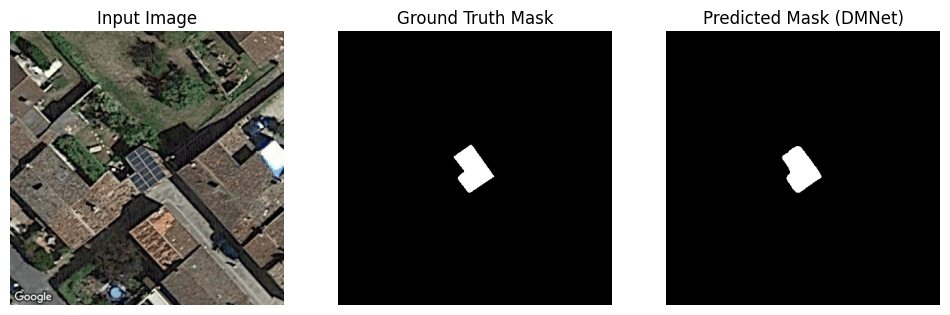

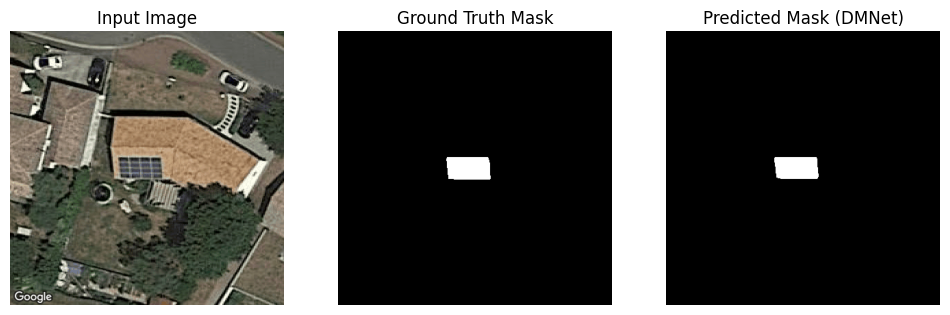

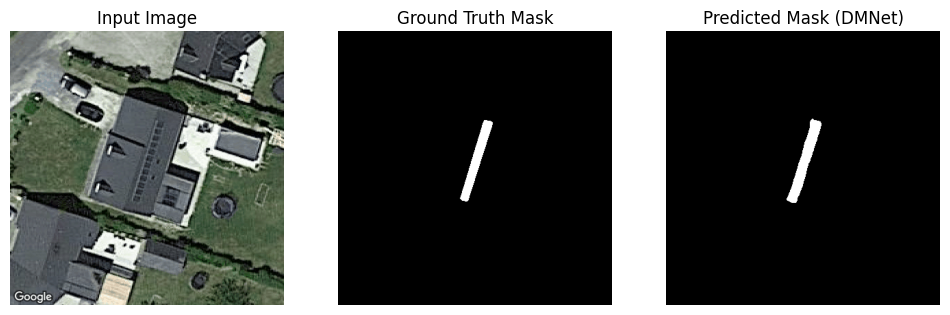

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# ------------------------------
# Load best model checkpoint
# ------------------------------
model = DMNet().to(device)
model.load_state_dict(torch.load(f"{SAVE_DIR}/best_dmnet.pth", map_location=device))
model.eval()

print("Loaded model from:", f"{SAVE_DIR}/best_dmnet.pth")

# ------------------------------
# Helper to run inference
# ------------------------------
def predict_mask(model, image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(image_tensor)
    pred = (pred[0,0].cpu().numpy() > 0.5).astype(np.uint8)
    return pred

# ------------------------------
# Show Image + GT Mask + Pred Mask
# ------------------------------
def visualize_sample(idx):
    img_path = os.path.join(val_dataset.img_dir, val_dataset.images[idx])
    mask_path = os.path.join(val_dataset.mask_dir, val_dataset.masks[idx])

    # load raw images
    raw_img = np.array(Image.open(img_path).convert("RGB"))
    raw_mask = np.array(Image.open(mask_path).convert("L")) // 255

    # load transformed dataset version
    img_tensor, mask_tensor = val_dataset[idx]
    pred_mask = predict_mask(model, img_tensor)

    # ---- Plot all three ----
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(raw_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(raw_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask (DMNet)")
    plt.axis("off")

    plt.show()

# ------------------------------
# 👉 Show 3 chosen samples
# Just replace these indices with your selected images
# ------------------------------
visualize_sample(0)
visualize_sample(5)
visualize_sample(10)


In [18]:
num_params = sum(p.numel() for p in model.parameters())
num_params_million = num_params / 1e6
print(f"Model Parameters: {num_params_million:.2f}M")


Model Parameters: 29.77M


In [19]:
import time
dummy_input = torch.randn(1, 3, 400, 400).to(device)

model.eval()
start = time.time()
with torch.no_grad():
    _ = model(dummy_input)
end = time.time()

print(f"Inference time: {(end - start) * 1000:.2f} ms")


Inference time: 9.08 ms


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        preds = (model(images) > 0.5).float()
        all_preds.append(preds.cpu().numpy().ravel())
        all_targets.append(masks.cpu().numpy().ravel())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

# IoU
intersection = np.logical_and(all_preds, all_targets).sum()
union = np.logical_or(all_preds, all_targets).sum()
miou = intersection / union

print(f"mIoU: {miou*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")


mIoU: 91.85%
Precision: 96.00%
Recall: 95.51%
F1 Score: 95.75%


In [21]:
print("\n=== Computer Configuration ===")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"RAM:  {round(os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024**3), 2)} GB")
print("OS:", os.uname())
print("CUDA:", torch.version.cuda)
print("PyTorch:", torch.__version__)



=== Computer Configuration ===
GPU: NVIDIA L4
RAM:  52.96 GB
OS: posix.uname_result(sysname='Linux', nodename='a948dc620ad4', release='6.6.105+', version='#1 SMP Thu Oct  2 10:42:05 UTC 2025', machine='x86_64')
CUDA: 12.6
PyTorch: 2.8.0+cu126
